In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from aidino.detector import Detector
from aidino.sample import Crystal
from aidino.diffraction import BraggCoherentDiffraction
from aidino.beam import GaussianBeam
from aidino.sample import load_displacement_npz
from aidino.plot_utils import format_axis
from aidino.xpcs import calculate_two_time_correlation, create_annulus_mask, draw_annulus_mask

In [2]:
dtype = torch.float32
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(dtype)

In [3]:
wavelength = 1.55e-10

detector = Detector(
    num_pixels_i = 128,
    num_pixels_j = 128,
    pixel_size = 75e-6,
    distance = 0.125,
    wavelength = wavelength,
    dtype = dtype,
    device = device
)
resolution = detector.calculate_resolution()
print(f'Detector resolution (ΔX): {resolution:.2g} m')

crystal = Crystal(
    'cifs/BaTiO3.cif',
    crystal_size = (192,192,16),
    wavelength = wavelength,
    include_anomalous = True,
    dtype = dtype,
    device = device
)

lengths = crystal.lattice_vectors.norm(dim=1)
print('Crystal size:', ' nm x '.join('{:.1f}'.format(crystal.crystal_size[i] * lengths[i] * 1e9) for i in range(len(lengths))), 'nm')

simulator = BraggCoherentDiffraction(
    crystal = crystal,
    dtype = dtype,
    device = device
)

Detector resolution (ΔX): 2e-09 m
Crystal size: 76.9 nm x 76.9 nm x 6.4 nm


In [4]:
crystal.visualize_structure()

Display size reduced to (49, 49, 4) to stay within 50,000 atom display limit.
Visualizing crystal of size (49, 49, 4) (48020 atoms)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

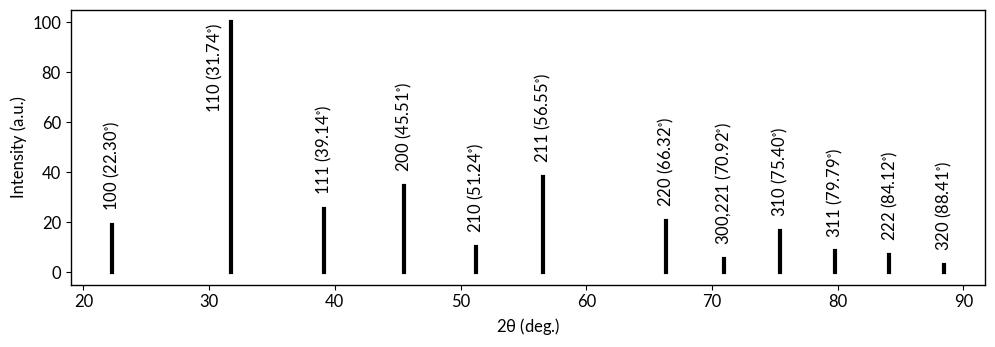

In [5]:
fig = crystal.get_xrd_pattern()

In [6]:
crystal.list_reflections()

  h   k   l     2θ (degrees)
-----------------------------------
  1   0   0        22.300047
  1   1   0        31.742749
  1   1   1        39.137976
  2   0   0        45.505754
  2   1   0        51.240921
  2   1   1        56.546747
  2   2   0        66.317051
  3   0   0        70.920204
  2   2   1        70.920204
  3   1   0        75.398536
  3   1   1        79.787265
  2   2   2        84.116107
  3   2   0        88.411425
-----------------------------------
Total reflections: 13


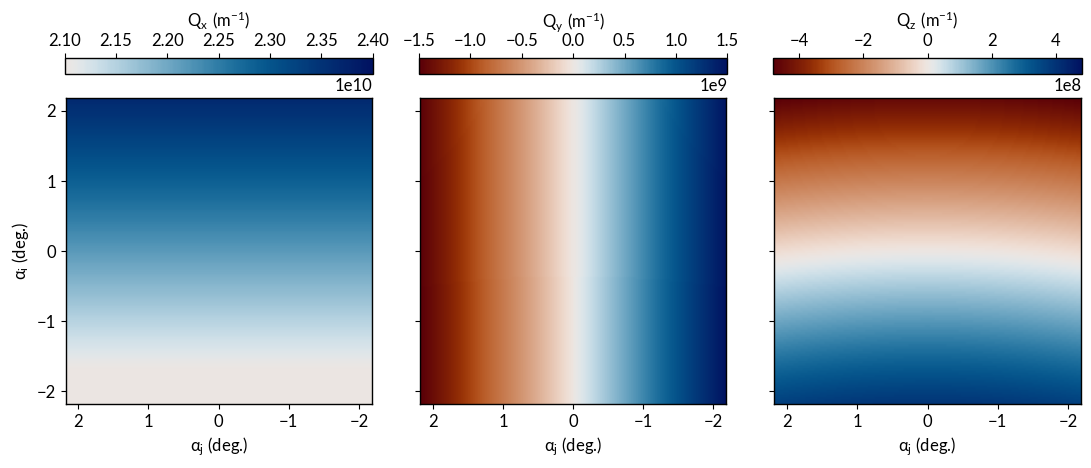

In [7]:
crystal.align_miller_plane_to_axis((1,1,0), target_axis='x')

theta_B = torch.deg2rad(torch.tensor(31.74 / 2., dtype=dtype, device=device))
k_i = torch.tensor([torch.sin(-theta_B), 0.0, torch.cos(-theta_B)], dtype=dtype, device=device)
k_f = torch.tensor([torch.sin(theta_B), 0.0, torch.cos(theta_B)], dtype=dtype, device=device)

q_vectors = detector.calculate_q_vectors(k_i, k_f)
fig = detector.plot_q_vectors(q_vectors)

In [8]:
# Require that supercell approximation remains below experiment resolution, i.e. d_i * a_i < ΔX
print('ΔX:', ','.join('{:d}'.format(int(resolution / lengths[i].item())) for i in range(len(lengths))), 'cells')
print('ΔX^3:', '{:d}'.format(np.prod([int(resolution / lengths[i].item()) for i in range(len(lengths))])), 'cells')
print('Oversampling ratio:', detector.calculate_oversampling_ratio(crystal.crystal_volume).item())

ΔX: 5,5,5 cells
ΔX^3: 125 cells
Oversampling ratio: 3.8431146144866943


In [9]:
supercell_size = (4,4,4)
q_batch_size = 8

In [10]:
beam = GaussianBeam(
    wavelength = wavelength,
    fwhm = 50e-9,
    device = device
)

beam.create_profile(
    crystal = crystal,
    supercell_size = supercell_size,
    k_i = k_i
)

Auto beam entry: -z face in lab frame → crystal axis c (- direction), 
Beam_center: (96.0, 96.0, 2.0)


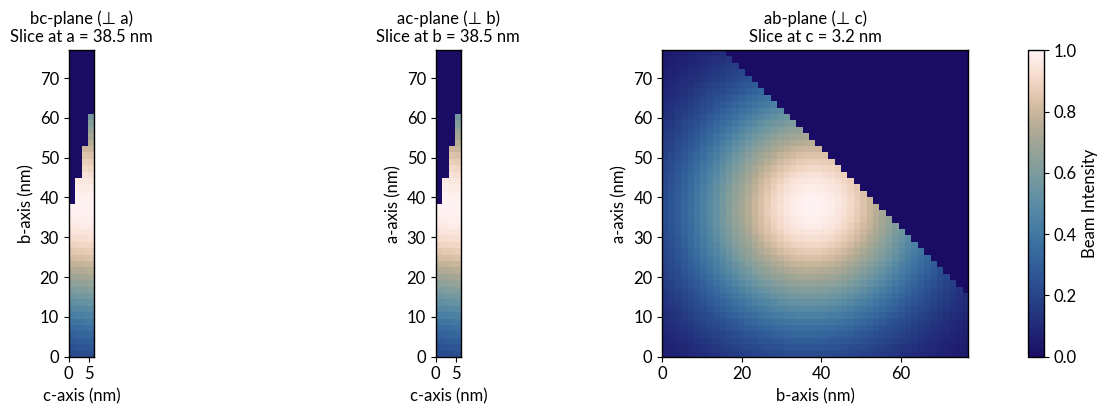

In [11]:
fig = beam.plot_profile(
    crystal = crystal,
    supercell_size = supercell_size
)

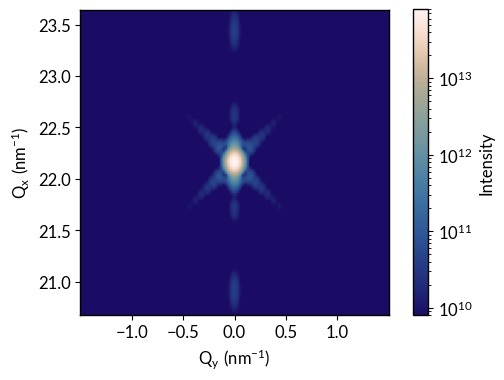

In [12]:
amplitude = simulator.calculate_supercell_scattering(q_vectors, supercell_size, mask=beam.profile, q_batch_size=q_batch_size)
intensity = (amplitude.abs() ** 2)
fig = detector.plot_intensity(intensity[0], q_vectors)

In [13]:
displacement_field = torch.stack(list(load_displacement_npz('trajectories/BaTiO3.npz', dtype=dtype, device=device).values()), dim=-2)

In [14]:
amplitude = simulator.calculate_supercell_scattering_with_displacements(q_vectors, supercell_size, displacement_field=displacement_field,
                                                                        mask=beam.profile, q_batch_size=q_batch_size)
intensity = (amplitude.abs() ** 2)

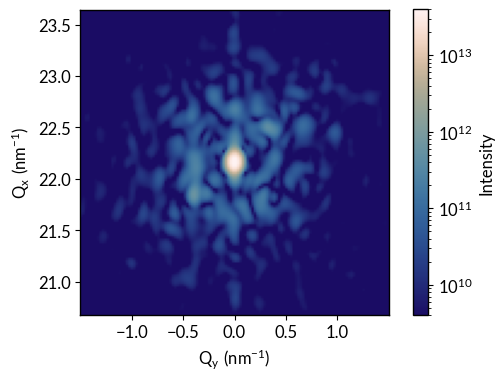

In [15]:
fig = detector.plot_intensity(intensity[0], q_vectors)

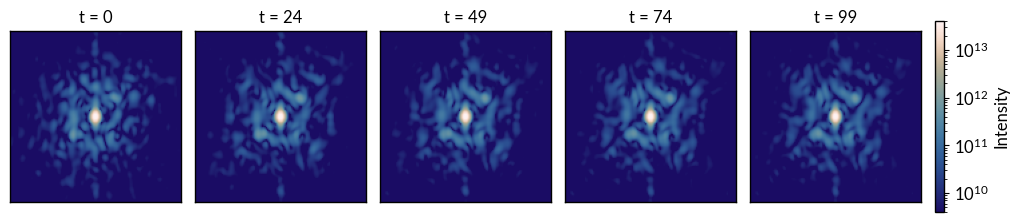

In [17]:
cmap = cm.lapaz
vmax = Detector.round_in_base(intensity[0].max().item(), digits=1)
vmin = vmax / 1e4 if vmax >= 1e4 else 1
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax, clip=1)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(1,6, figsize=(10,2.5), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, timestep in enumerate(np.linspace(0, len(intensity)-1, len(ax) - 1, dtype=int)):
    ax[i].imshow(intensity[timestep].cpu(), origin='lower', cmap=cmap, norm=norm)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    format_axis(ax[i], title=f't = {timestep}')

plt.colorbar(sm, cax=ax[-1])
format_axis(ax[-1], ylabel='Intensity')

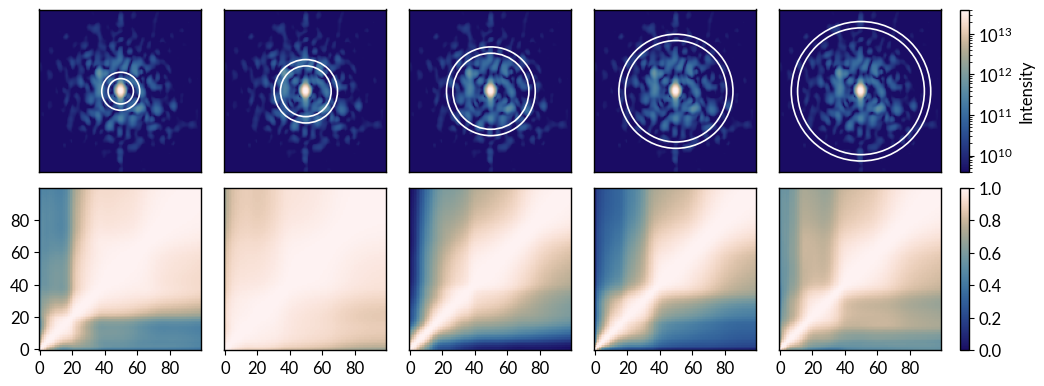

In [18]:
cmap = cm.lapaz
vmax = Detector.round_in_base(intensity[0].max().item(), digits=1)
vmin = vmax / 1e4 if vmax >= 1e4 else 1
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax, clip=1)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

norm_c2 = plt.Normalize(vmin=0., vmax=1.)
sm_c2 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_c2)

fig, ax = plt.subplots(2,6, figsize=(10,4), gridspec_kw={'width_ratios':[1] * 5 + [0.05]})
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)

radii = intensity.shape[-1] // 2 // 6 * np.arange(1,6)
width = 5
for i in range(ax.shape[1] - 1):
    roi = create_annulus_mask(*intensity.shape[1:], radii[i], width)
    
    ax[0,i].imshow(intensity[0].cpu(), cmap=cmap, norm=norm)
    draw_annulus_mask(
        ax[0,i],
        r_inner=radii[i],
        width=width,
        center=(intensity.shape[1] // 2,intensity.shape[2] // 2),
        lw=1.2,
        color="white",
    )
    
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    C2 = calculate_two_time_correlation(intensity[:,roi].flatten(start_dim=1))
    ax[1,i].imshow(C2.cpu(), origin='lower', interpolation='none', cmap=cmap, norm=norm_c2)
    format_axis(ax[1,i], xbins=5, ybins=5)
    if i > 0:
        ax[1,i].set_yticks([])

plt.colorbar(sm, cax=ax[0,-1])
format_axis(ax[0,-1], ylabel='Intensity')

plt.colorbar(sm_c2, cax=ax[1,-1])
format_axis(ax[1,-1])